In [1]:
import pyprob
%matplotlib inline
import matplotlib.pyplot as plt
from pyprob import Model
import numpy as np

# Intro into `pyprob`

`pyprob` is very easy. You only need to subclass `pyprob.Model` and add a `forward()` method that implements your generative model. Within the body of the model you can use `pyprob.sample` and `pyprob.observe` which are the necessary keywords of a probabilistic programming language.

In this case it's a model which draws to random numbers `a` and `b` and draws the final value from a Gaussian with mean `a+b`, whatever their value was, with a small standard deviation.

You can try thinking about what the posterior p(x,z) of prior p(z) look like.

In [4]:
import math
import pyprob
from pyprob import Model
from pyprob.distributions import Normal

class SimpleGaussian(Model):
    def __init__(self):
        super().__init__(name="Simple Gaussian") # give the model a name
        self.prior_mean = 1
        self.prior_std = 4
        self.likelihood_std = 0.5

    def forward(self): # Needed to specifcy how the generative model is run forward
        # sample the (latent) mean variable to be inferred:
        a = pyprob.sample(Normal(self.prior_mean, self.prior_std), name = 'input1') # NOTE: sample -> denotes latent variables
        b = pyprob.sample(Normal(self.prior_mean, self.prior_std), name = 'input2') # NOTE: sample -> denotes latent variables

        mu = a+b

        pyprob.observe(Normal(mu, self.likelihood_std), name='obs0') # NOTE: observe -> denotes observable variables
        return a,b

model = SimpleGaussian()

## Learning to Infer

inference means that we can efficiently get samples that follow the posterior `p(z|x)`. In the "inference compilation" method, we train a network that, when running the `forward()` will propose appropriate distribution to sample from such that the overall trace approaches the true posterior. Let's train this "smart ML agent" that will steer our simulation code in the right  direction.

In [5]:
model.learn_inference_network(
    num_traces=10000,
    observe_embeddings={'obs0': {'dim': 32, 'depth': 3}}
)

Creating new inference network...
Observable obs0: observe embedding not specified, using the default FEEDFORWARD.
Observe embedding dimension: 32
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Traces/sec
New layers, address: 20__forward__a__Normal__1, distribution: Normal
New layers, address: 44__forward__b__Normal__1, distribution: Normal
Total addresses: 2, parameters: 6,926
0d:00:00:06 | 1    | 10,048    | +5.77e+00 | +4.50e+00 | +5.08e+00 | 0d:00:00:02 | 1,053.0                              


Let's now collect some samples from both the prior and the posterior so we can compare

In [7]:
condition  = {'obs0': 2}

prior = model.prior_distribution(
    num_traces=1000,
)
posterior = model.posterior_distribution(
    num_traces=1000,
    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK,
    observe=condition
)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 2,388.31       
Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 1000/1000 | 332.45       


In [8]:
edges = np.linspace(-10,10, 25)

In [9]:
prior     = np.asarray([[x.item() for x in prior.sample()] for x in range(1000)])
posterior = np.asarray([[x.item() for x in posterior.sample()] for x in range(1000)])

## The conditioned posterior


As we plot the latent state of the simulator (the numbers `a` and `b`) below we see the effect of the conditioning. Conditioning on a particular value `c`  forces the relation `a+b = c` to approximately hold (within the range of the standard deviation). What will happen if you decreate the standard deviation?

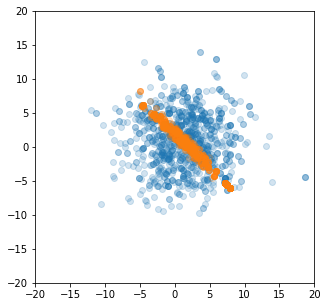

In [11]:
plt.scatter(prior[:,0],prior[:,1], alpha = 0.2)
plt.scatter(posterior[:,0],posterior[:,1], alpha = 0.2)
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.gcf().set_size_inches(5,5)